## Initialisation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
from IPython.display import clear_output
sns.set()

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Available device =", device)

## Fetch the dataset

from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/gdrive', force_remount=False)

# Uncomment if running via google colab
# (you might need to change the paths in this case)
def_colab_path = '/gdrive/My Drive/Colab Notebooks/Lambda/CaloGAN/'
train_data_path = def_colab_path + 'data/data_train.npz'
val_data_path   = def_colab_path + 'data/data_val.npz'
test_data_path  = def_colab_path + 'data/data_test.npz'

# Uncomment if running locally
#train_data_path = '../data_train.npz'
#val_data_path   = '../data_val.npz'
#test_data_path  = '../data_test.npz'

# Get the technical functions
! wget https://raw.githubusercontent.com/TheodorSergeev/mlhep2019_2_phase/master/analysis/calogan_metrics.py
! wget https://raw.githubusercontent.com/TheodorSergeev/mlhep2019_2_phase/master/analysis/prd_score.py
! wget https://raw.githubusercontent.com/TheodorSergeev/mlhep2019_2_phase/master/analysis/score.py
! wget https://github.com/TheodorSergeev/mlhep2019_2_phase/raw/master/analysis/embedder.tp
! wget https://github.com/TheodorSergeev/mlhep2019_2_phase/raw/master/analysis/generator.py
! wget https://github.com/TheodorSergeev/mlhep2019_2_phase/raw/master/analysis/discriminator.py

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Available device = cuda
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
--2020-04-14 13:18:40--  https://raw.githubusercontent.com/TheodorSergeev/mlhep2019_2_phase/master/analysis/calogan_metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4115 (4.0K) [text/plain]
Saving to: ‘calogan_

## Load the data

In [0]:
def dataset_rotations_transform(data_arr):
    EnergyDeposit, ParticleMomentum, ParticlePoint, PDG = data_arr[:]
    N = len(PDG)

    transf_energy   = np.zeros((4, N, 1, 30, 30))
    transf_momentum = np.zeros((4, N, 3))
    transf_point    = np.zeros((4, N, 2))
    transf_pdg      = np.zeros((4, N, 1))

    for i in range(0,N):
        transf_energy  [0][i] = EnergyDeposit   [i]
        transf_momentum[0][i] = ParticleMomentum[i]
        transf_point   [0][i] = ParticlePoint   [i]
        transf_pdg     [0][i] = PDG             [i]

        for rotation_num in range(1,4):
            transf_energy  [rotation_num][i] = np.rot90(transf_energy[rotation_num - 1][i], axes=(1,2))
            
            transf_momentum[rotation_num][i][0] = -transf_momentum[rotation_num - 1][i][1] # p_x -> -p_y
            transf_momentum[rotation_num][i][1] = +transf_momentum[rotation_num - 1][i][0] # p_y -> p_x
            transf_momentum[rotation_num][i][2] = +transf_momentum[rotation_num - 1][i][2] # p_z -> p_z
            
            transf_point   [rotation_num][i][0] = -transf_momentum[rotation_num - 1][i][1] # x -> -y
            transf_point   [rotation_num][i][1] = +transf_momentum[rotation_num - 1][i][0] # y -> x

            transf_pdg[rotation_num][i] = PDG[i]

    transf_energy   = torch.tensor(np.concatenate(transf_energy,   axis=0)).float()
    transf_momentum = torch.tensor(np.concatenate(transf_momentum, axis=0)).float()
    transf_point    = torch.tensor(np.concatenate(transf_point,    axis=0)).float()
    transf_pdg      = torch.tensor(np.concatenate(transf_pdg,      axis=0)).float()
    return utils.TensorDataset(transf_energy, transf_momentum, transf_point, transf_pdg)


def get_datasets(data_arr, train_size, valid_size,
                 one_particle_transf=True, particle_id=11.,
                 rotate_transf=False, normalise_energies=False):
    np.random.seed(123)

    energy   = torch.tensor(data_arr['EnergyDeposit'].reshape(-1, 1, 30, 30)).float()
    momentum = torch.tensor(data_arr['ParticleMomentum']).float()
    point    = torch.tensor(data_arr['ParticlePoint'][:, :2]).float()
    pdg      = torch.tensor(data_arr['ParticlePDG']).float()
    data_arr = utils.TensorDataset(energy, momentum, point, pdg)

    if one_particle_transf:
        pdg = data_arr[:][3]
        one_particle_ind_arr = [i for i, x in enumerate(pdg) if x == particle_id]
        energy, momentum, point, pdg = data_arr[one_particle_ind_arr]
        data_arr = utils.TensorDataset(energy, momentum, point, pdg)

    if rotate_transf:
        data_arr = dataset_rotations_transform(data_arr)
    
    if normalise_energies:
        energy, momentum, point, pdg = data_arr[:]
        # standart scaling
        MEAN_ENERGY_MATRIX = energy.mean(axis=0).reshape(1,30,30)
        STD_ENERGY_MATRIX  = energy.std(axis=0).reshape(1,30,30)
        energy = (energy - MEAN_ENERGY_MATRIX) / STD_ENERGY_MATRIX

        # E \in [E_min, E_max] -> E \in [-1, 1]
        energy = energy / torch.max(energy.abs())
        #print('E_min = ', energy.min())
        #print('E_max = ', energy.max())
        data_arr = utils.TensorDataset(energy, momentum, point, pdg)

    dataset_len = len(data_arr)
    ind_arr = np.random.permutation(dataset_len)
    train_ind_arr = ind_arr[0:train_size]
    valid_ind_arr = ind_arr[train_size:train_size+valid_size]

    energy, momentum, point, pdg = data_arr[train_ind_arr]
    train_dataset = utils.TensorDataset(energy, momentum, point, pdg)

    energy, momentum, point, pdg = data_arr[valid_ind_arr]
    valid_dataset = utils.TensorDataset(energy, momentum, point, pdg)

    # sanity check
    # print(len(np.unique(np.concatenate((train_ind_arr, valid_ind_arr)))))

    return train_dataset, valid_dataset, train_ind_arr, valid_ind_arr

In [0]:
data_train = np.load(train_data_path, allow_pickle=False)

In [4]:
'''
data_train = np.load(train_data_path, allow_pickle=False)

# Test:
train_dataset, valid_dataset, ind_arr_1, ind_arr_2 = get_datasets(data_train, 23517, 1536, normalise_energies=True)

energy, momentum, point, pdg = train_dataset[:]
energy2, momentum2, point2, pdg2 = valid_dataset[:]
print(energy.max(), energy2.max())
print(energy.min(), energy2.min())

del train_dataset, valid_dataset, ind_arr_1, ind_arr_2;
'''

'\ndata_train = np.load(train_data_path, allow_pickle=False)\n\n# Test:\ntrain_dataset, valid_dataset, ind_arr_1, ind_arr_2 = get_datasets(data_train, 23517, 1536, normalise_energies=True)\n\nenergy, momentum, point, pdg = train_dataset[:]\nenergy2, momentum2, point2, pdg2 = valid_dataset[:]\nprint(energy.max(), energy2.max())\nprint(energy.min(), energy2.min())\n\ndel train_dataset, valid_dataset, ind_arr_1, ind_arr_2;\n'

## Plot functions

In [0]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tck

def plot_energy_distr_real_generated(energ_distr_real, 
                                     energ_distr_generated):
    f, ax = plt.subplots(1,2, figsize=(10, 4))
    f.suptitle("Energy distribution", fontsize=16, y=.9)

    vmin = torch.max(energ_distr_real) 
    vmin = min(vmin, torch.min(energ_distr_generated))
    vmax = torch.max(energ_distr_real) 
    vmax = max(vmax, torch.max(energ_distr_generated))

    for i, title, en_dep in zip([0,1], ["Real", "Generated"],
                                [energ_distr_real[0], energ_distr_generated[0]]):
        ax[i].set_title (title,  fontsize=14)
        ax[i].set_xlabel(r'$x$', fontsize=12)
        ax[i].set_ylabel(r'$y$', fontsize=12)

        ax[i].set_xticks(np.arange(-0.5, 30., 1.), minor=True)
        ax[i].set_xticks(np.arange(-0.5, 30., 5.), minor=False)                    
        ax[i].set_xticklabels(np.arange(-15, 16, 5), minor=False, fontsize=10)

        ax[i].set_yticks(np.arange(-0.5, 30., 1.), minor=True)
        ax[i].set_yticks(np.arange(-0.5, 30., 5.), minor=False)                    
        ax[i].set_yticklabels(np.arange(-15, 16, 5), minor=False, fontsize=10)

        ax[i].grid(which='both', color='dimgray', linestyle='-', linewidth=0.5)
        im = ax[i].imshow(en_dep, origin = 'lower', cmap="inferno", 
                          vmin=vmin)#, vmax=vmax)

        divider = make_axes_locatable(ax[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.subplots_adjust(wspace=0.1, hspace=0.05, top = 0.75)
    #plt.show()
    return


def plot_shower_real_generated(energ_distr_real, 
                               energ_distr_generated):
    f, ax = plt.subplots(1,2, figsize=(10, 4))
    f.suptitle("Shower", fontsize=16, y=.9)

    for i, title, en_dep in zip([0,1], ["Real", "Generated"],
                                [energ_distr_real[0], energ_distr_generated[0]]):
        ax[i].set_title (title,  fontsize=14)
        ax[i].set_xlabel(r'Cluster traverse width ($x$)', fontsize=12)
        ax[i].set_ylabel(r'Arbitrary units (sum along $y$)', fontsize=12)

        ax[i].set_xticks(np.arange(-0.5, 30., 1.), minor=True)
        ax[i].set_xticks(np.arange(-0.5, 30., 5.), minor=False)                    
        ax[i].set_xticklabels(np.arange(-15, 16, 5), minor=False, fontsize=10)

        ax[i].bar(np.arange(0,30), torch.sum(en_dep, axis=0), 
                  width=1.0, align='edge', edgecolor='black')

    plt.subplots_adjust(hspace=0.05, top = 0.75)
    return


def plot_energy_and_shower(energ_distr_real, energ_distr_generated):
    f, ax = plt.subplots(2,2, figsize=(8, 8))
    #f.suptitle("Energy distribution", fontsize=16, y=.9)

    vmin = torch.max(energ_distr_real) 
    vmin = min(vmin, torch.min(energ_distr_generated))
    vmax = torch.max(energ_distr_real) 
    vmax = max(vmax, torch.max(energ_distr_generated))

    for i, distr_type, en_dep in zip([0,1], ["Real", "Generated"],
                                [energ_distr_real[0], energ_distr_generated[0]]):
        for j, distr_name in zip([0,1], ["energy distribution", "shower"]):
            ax[j][i].set_title (distr_type + " " + distr_name,  fontsize=14)
            ax[j][i].set_xticks(np.arange(-0.5, 30., 1.), minor=True)
            ax[j][i].set_xticks(np.arange(-0.5, 30., 5.), minor=False)                    
            ax[j][i].set_xticklabels(np.arange(-15, 16, 5), minor=False, fontsize=10)

        ax[0][i].set_xlabel(r'$x$', fontsize=12)
        ax[0][i].set_ylabel(r'$y$', fontsize=12)
        ax[1][i].set_xlabel(r'Cluster traverse width ($x$)', fontsize=12)
        ax[1][i].set_ylabel(r'Arbitrary units (sum along $y$)', fontsize=12)

        ax[0][i].set_yticks(np.arange(-0.5, 30., 1.), minor=True)
        ax[0][i].set_yticks(np.arange(-0.5, 30., 5.), minor=False)                    
        ax[0][i].set_yticklabels(np.arange(-15, 16, 5), minor=False, fontsize=10)

        # plot shower
        ax[1][i].bar(np.arange(0,30), torch.sum(en_dep, axis=0), 
                  width=1.0, align='edge', edgecolor='black')

        # plot energy distribution
        ax[0][i].grid(which='both', color='dimgray', linestyle='-', linewidth=0.5)
        im = ax[0][i].imshow(en_dep, origin = 'lower', cmap="inferno", 
                          vmin=vmin)#, vmax=vmax)

        # add colorabar for the energy distributions
        divider = make_axes_locatable(ax[0][i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    #plt.show()
    return

## GAN loss functions

In [0]:
TASKS = ['KL', 'REVERSED_KL', 'WASSERSTEIN', 'HINGE']

TASK = 'HINGE'

# Additional things for Wasserstein GAN
LIPSITZ_WEIGHTS = False
clamp_lower, clamp_upper = -0.01, 0.01

GRAD_PENALTY = True                  # https://arxiv.org/abs/1704.00028
ZERO_CENTERED_GRAD_PENALTY = False   # https://arxiv.org/abs/1705.09367

# Small hack that can speed-up training and improve generalization
INSTANCE_NOISE = True                # https://arxiv.org/abs/1610.04490

def add_instance_noise(data, std=0.01):
    return data + torch.distributions.Normal(0, std).sample(data.shape).to(device)

def l2_norm(tensor):
    """Return the l2 norm of a tensor."""
    return torch.sqrt(1e-8 + torch.sum(tensor**2))

In [0]:
class GANLosses(object):
    def __init__(self, task, device, gp = 'local-two-sided'):
        self.TASK = task
        self.device = device
        self.GP = gp
    
    def g_loss(self, discrim_output):
        eps = 1e-10
        if self.TASK == 'KL': 
            loss = torch.log(1 - discrim_output + eps).mean()    
        elif self.TASK == 'REVERSED_KL':
            loss = - torch.log(discrim_output + eps).mean()
        elif self.TASK in ['WASSERSTEIN', 'HINGE']:
            loss = - discrim_output.mean()
        return loss

    def d_loss(self, discrim_output_gen, discrim_output_real):
        eps = 1e-10
        if self.TASK in ['KL', 'REVERSED_KL']: 
            loss = - torch.log(discrim_output_real + eps).mean() - torch.log(1 - discrim_output_gen + eps).mean()
        elif self.TASK == 'WASSERSTEIN':
            loss = - (discrim_output_real.mean() - discrim_output_gen.mean())
        elif self.TASK == 'HINGE':
            loss = torch.nn.ReLU()(1.0 - discrim_output_real).mean() + torch.nn.ReLU()(1.0 + discrim_output_gen).mean()
        return loss

    def calc_gradient_penalty(self, discriminator, data_gen, inputs_batch, inp_data, lambda_reg = .1):
        gradient_penalty = 0
        k = 1

        if self.GP == 'local-two-sided':
            N = 10

            noise_y = torch.normal(0, N, size=inp_data.shape).to(self.device)

            perturbed_y = (inp_data + noise_y).to(self.device)

            perturbed_y.requires_grad = True

            disc_interpolates = discriminator(perturbed_y, inputs_batch)

            gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=perturbed_y,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]

            gradient_penalty = ((l2_norm(gradients) - k) ** 2).mean() * lambda_reg

        elif self.GP == 'original':
            alpha = torch.rand(inp_data.shape[0], 1).to(self.device)
            dims_to_add = len(inp_data.size()) - 2
            for i in range(dims_to_add):
                alpha = alpha.unsqueeze(-1)
                # alpha = alpha.expand(inp_data.size())

            interpolates = (alpha * inp_data + ((1 - alpha) * data_gen)).to(self.device)

            interpolates.requires_grad = True

            disc_interpolates = discriminator(interpolates, inputs_batch)

            gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]

            gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_reg

        return gradient_penalty
    
    def calc_zero_centered_GP(self, discriminator, data_gen, inputs_batch, inp_data, gamma_reg = .1):
        
        local_input = inp_data.clone().detach().requires_grad_(True)
        disc_interpolates = discriminator(local_input, inputs_batch)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=local_input,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]
        return gamma_reg / 2 * (gradients.norm(2, dim=1) ** 2).mean() 

## Training procedure

In [0]:
from prd_score import compute_prd, compute_prd_from_embedding, _prd_to_f_beta
from sklearn.metrics import auc

def prd_auc(generated_example, real_example, reshape_size):
    precision, recall = compute_prd_from_embedding(
                            generated_example.reshape(reshape_size, -1), 
                            real_example.reshape(reshape_size, -1),
                            num_clusters=30, num_runs=100)
    return auc(precision, recall)

NOISE_DIM = 10

class TrainingProcedure:

    def __init__(self, loss_function_type, discriminator, generator, vae_pretrained,
                 train_dataloader, valid_dataloader,
                 batch_size, valid_size,
                 lr_dis = 4e-4, lr_gen = 1e-4,
                 dis_iter_num = 3, gen_iter_num = 1, noise_dim = NOISE_DIM):

        self.current_epoch = 0
        self.gan_losses = GANLosses(TASK, device)
        self.discriminator = discriminator.to(device)
        self.generator = generator.to(device)
        self.VAE = vae_pretrained.to(device)

        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.BATCH_SIZE = batch_size
        self.VALID_SIZE = valid_size
        self.noise_dim  = noise_dim

        # array for saving the distributions that are generated on every step
        self.DRAW_ID = 8
        energy, _, _, _ = self.valid_dataloader.dataset[self.DRAW_ID]
        self.generated_examples_list = [energy] # first element is the real distribution

        self.best_models = [self.discriminator, self.generator]

        self.g_optimizer = optim.Adam(self.generator.parameters(), betas=(0.0, 0.999), lr=lr_gen)
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), betas=(0.0, 0.999), lr=lr_dis)

        self.k_d = dis_iter_num
        self.k_g = gen_iter_num
        
        self.dis_epoch_loss,  self.gen_epoch_loss  = [], []
        self.predictions_dis, self.predictions_gen = [], []
        self.prd_auc = []  

        self.val_prd_auc = []

        return

    def run(self, epoch_num, use_separate_validation=False):
        for epoch in tqdm(np.arange(self.current_epoch, epoch_num)):      
            # Validation
            if use_separate_validation:
                self.validation()        
            
            # Training
            self.generator.train()
            self.discriminator.train()
            first = True

            for energy_b, mom_b, point_b, pdg_b in self.train_dataloader:
                
                energy_b, mom_b = energy_b.to(device), mom_b.to(device)
                point_b,  pdg_b = point_b .to(device), pdg_b.to(device)
                mom_point_b = torch.cat([mom_b.to(device), point_b.to(device)], dim=1)

                if first:
                    noise = torch.randn(len(energy_b), self.noise_dim).to(device)
                    vae_energy_b = self.VAE.decode(noise, mom_point_b)
                    energy_gen = self.generator(noise, mom_point_b, vae_energy_b)
                    
                    pred_dis_list = list(self.discriminator(energy_b,   mom_point_b).detach().cpu().numpy().ravel())
                    pred_gen_list = list(self.discriminator(energy_gen, mom_point_b).detach().cpu().numpy().ravel())
                    
                    self.predictions_dis.append(pred_dis_list)
                    self.predictions_gen.append(pred_gen_list)
                    
                # Optimize D
                dis_loss_item = self.train_epoch_dis(self.k_d, energy_b, mom_point_b)
                self.dis_epoch_loss.append(dis_loss_item)

                # Optimize G
                gen_loss_item = self.train_epoch_gen(self.k_g, energy_b, mom_point_b)
                self.gen_epoch_loss.append(gen_loss_item)

                if first:
                    reshape_size = pdg_b.shape[0] # = BATCH_SIZE or less
                    self.prd_auc.append(prd_auc(energy_gen.detach().cpu().numpy(),
                                                energy_b  .detach().cpu().numpy(), 
                                                reshape_size))
                    first = False
            
            # Save the new model if it is the best one (max training prd)
            if self.prd_auc[-1] == np.max(self.prd_auc):
                print("New best model")
                self.best_models = [self.discriminator, self.generator]

            # Plot training progress

            self.generator.eval()
            self.discriminator.eval()

            with torch.no_grad():
                energy_b, mom_b, point_b, pdg_b = self.valid_dataloader.dataset[self.DRAW_ID]

                energy_b = energy_b.reshape((1,1,30,30))
                point_b  = point_b.reshape((1,2))
                mom_b    = mom_b.reshape((1,3))
                pdg_b    = pdg_b.reshape((1,1))

                noise = torch.randn(len(energy_b), self.noise_dim).to(device)
                mom_point_b = torch.cat([mom_b.to(device), point_b.to(device)], dim=1)
                vae_energy_b = self.VAE.decode(noise, mom_point_b)

                energy_gen = self.generator(noise, mom_point_b, vae_energy_b)
                real_res = energy_b  .detach().cpu()[0]
                gen_res  = energy_gen.detach().cpu()[0]

                self.generated_examples_list.append(gen_res) # save the generated example

                if not use_separate_validation:
                    self.val_prd_auc = self.prd_auc # заглушка, чтобы сильно не менять функцию построения графиков

                self.plot_training_progress(epoch, real_res, gen_res)

            self.current_epoch += 1  

        return

    def train_epoch_dis(self, k_d, energy_b, mom_point_b):
        """
        Train discriminator for one epoch
        
            Parameters
            ----------
                k_d : int
                    Number of iterations to train for.
                
                energy_b : torch.Tensor
                    Batch of energy distributions.
                
                mom_point_b : torch.Tensor
                    Batch of concatenated particle momentum and entrance point.
                                
            Returns:
            ----------
                loss.item() : float
                    Loss on the last iteration of training.
        """

        for _ in range(k_d):
            noise = torch.randn(len(energy_b), self.noise_dim).to(device)
            vae_energy_b = self.VAE.decode(noise, mom_point_b)

            energy_gen = self.generator(noise, mom_point_b, vae_energy_b)

            if INSTANCE_NOISE:
                energy_b   = add_instance_noise(energy_b)
                energy_gen = add_instance_noise(energy_gen)
                
            loss = self.gan_losses.d_loss(self.discriminator(energy_gen, mom_point_b),
                                          self.discriminator(energy_b,   mom_point_b))
        
            coef = 0
            if GRAD_PENALTY:
                coef = +1.
            elif ZERO_CENTERED_GRAD_PENALTY:
                coef = -1.

            loss += coef * self.gan_losses.calc_gradient_penalty(self.discriminator,
                                                            energy_gen.data,
                                                            mom_point_b,
                                                            energy_b.data)
            self.d_optimizer.zero_grad()
            loss.backward()
            self.d_optimizer.step()

            if LIPSITZ_WEIGHTS:                    
                [p.data.clamp_(clamp_lower, clamp_upper) for p in self.discriminator.parameters()]

        return loss.item()


    def train_epoch_gen(self, k_g, energy_b, mom_point_b):
        """
        Train generator for one epoch
        
            Parameters
            ----------
                k_g : int
                    Number of iterations to train for.
                
                energy_b : torch.Tensor
                    Batch of energy distributions.
                
                mom_point_b : torch.Tensor
                    Batch of concatenated particle momentum and entrance point.
                                
            Returns:
            ----------
                loss.item() : float
                    Loss on the last iteration of training.
        """

        for _ in range(k_g):
            noise = torch.randn(len(energy_b), self.noise_dim).to(device)
            vae_energy_b = self.VAE.decode(noise, mom_point_b)
            energy_gen = self.generator(noise, mom_point_b, vae_energy_b)

            if INSTANCE_NOISE:
                energy_b = add_instance_noise(energy_b)
                energy_gen = add_instance_noise(energy_gen)
            
            loss = self.gan_losses.g_loss(self.discriminator(energy_gen, mom_point_b))
            
            self.g_optimizer.zero_grad()
            loss.backward()
            self.g_optimizer.step()

        return loss.item()

    def validation(self):
        self.generator.eval()
        self.discriminator.eval()

        with torch.no_grad():

            #val_predictions_dis, val_predictions_gen = [], []
            val_energy_b, val_energy_gen  = [], []

            for energy_b, mom_b, point_b, pdg_b in self.valid_dataloader:
                energy_b, mom_b = energy_b.to(device), mom_b.to(device)
                point_b,  pdg_b = point_b .to(device), pdg_b.to(device)
                mom_point_b = torch.cat([mom_b.to(device), point_b.to(device)], dim=1)
                noise = torch.randn(len(energy_b), self.noise_dim).to(device)
                vae_energy_b = self.VAE.decode(noise, mom_point_b)

                energy_gen = self.generator(noise, mom_point_b, vae_energy_b)
                
                val_energy_b.append(energy_b.detach().cpu().numpy())
                val_energy_gen.append(energy_gen.detach().cpu().numpy())

                #pred_dis_list = list(self.discriminator(energy_b,   mom_point_b).detach().cpu().numpy().ravel())
                #pred_gen_list = list(self.discriminator(energy_gen, mom_point_b).detach().cpu().numpy().ravel())
                
                #val_predictions_dis.append(pred_dis_list)
                #val_predictions_gen.append(pred_gen_list)

            val_energy_gen = np.concatenate(val_energy_gen, axis=0)
            val_energy_b   = np.concatenate(val_energy_b,   axis=0)

            self.val_prd_auc.append(prd_auc(val_energy_gen, val_energy_b, 
                                            self.VALID_SIZE))
        return

    def plot_training_progress(self, epoch, example_real, example_gen):
        """
        Plot training curves (loss, discrimination quality, prd-auc) and draw
        real/generated energy distributions and showers.
        
            Parameters
            ----------
                epoch : int
                    Current epoch number.
                
                example_real : torch.Tensor 30x30x1
                    Random energy distribution from the training dataset.
                
                example_gen : torch.Tensor
                    Generated energy distribution for the emaple from the 
                    training dataset. Real distribution is passed in example_real.
        """

        clear_output()

        print('Epoch #%d\nMean discriminator output on real data = %g\n'\
              'Mean discriminator output on generated data = %g' % 
              (epoch, np.mean(self.predictions_dis[-1]), np.mean(self.predictions_gen[-1])))
        
        fs_title = 14
        fs_axis = 12
        fs_ticks = 10

        f, ax = plt.subplots(1,3, figsize=(20, 5))
        ax[0].set_title ('Training loss', fontsize=fs_title)
        ax[0].set_xlabel('Epoch',     fontsize=fs_axis)
        ax[0].set_ylabel('Loss',          fontsize=fs_axis)

        ax[0].set_xticks     (np.linspace(0.0, len(self.dis_epoch_loss), 5))
        ax[0].set_xticklabels(np.linspace(0.0, epoch, 5))
        ax[0].plot(self.dis_epoch_loss, label='discriminator', color = 'red',  alpha=0.5)
        ax[0].plot(self.gen_epoch_loss, label='generator',     color = 'blue', alpha=0.5)
        ax[0].legend()

        ax[1].set_title ('Discrimination quality', fontsize=fs_title)
        ax[1].set_xlabel('Discriminator output',   fontsize=fs_axis)
        ax[1].set_ylabel('Number of examples',     fontsize=fs_axis)
        # get the bin edges to get an equal bin size for both distributions
        bins = np.histogram(np.hstack((self.predictions_dis[-1],
                                    self.predictions_gen[-1])), bins=100)[1]
        ax[1].hist(self.predictions_dis[-1], bins, label='real',      color = 'red',  ec='darkred',  alpha=0.5)
        ax[1].hist(self.predictions_gen[-1], bins, label='generated', color = 'blue', ec='darkblue', alpha=0.5)
        ax[1].legend()

        ax[2].set_xticks     (np.linspace(0.0, epoch, 5))
        ax[2].set_xticklabels(np.linspace(0.0, epoch, 5))
        ax[2].set_title ('PRD AUC', fontsize=fs_title)
        ax[2].set_xlabel('Epoch',   fontsize=fs_axis)
        ax[2].set_ylabel('PRD AUC', fontsize=fs_axis)
        #ax[2].set_xticks(np.arange(0,epoch))
        ax[2].plot(self.prd_auc,     label="Training",  color='red')
        ax[2].plot(self.val_prd_auc, label="Validaion", color='blue')
        ax[2].legend()

        #plot_energy_distr_real_generated(example_real, example_gen)
        #plot_shower_real_generated(example_real, example_gen) 
        plot_energy_and_shower(example_real, example_gen)
        plt.show()
        
        return

In [0]:
def train_model(epoch_num, particle_type_id, discriminator, generator, vae_pretrained,
                train_size = 16000, valid_size = -1, valid_ratio = 0.05, 
                batch_size = 512, dis_iter_num = 3, gen_iter_num = 1, 
                noise_dim = 30, if_normalise_energies=False, if_rotate_dataset=False,
                loss_type='HINGE'):
    MAX_TRAIN_SIZE = data_train['ParticlePDG'].shape[0]
    
    if valid_size < 0:
        valid_size = int(valid_ratio * train_size)

    if_one_particle_transf = True
    
    if particle_type_id < 0:
        if_one_particle_transf = False

    train_dataset, valid_dataset, _, _ = get_datasets(data_train, train_size, valid_size,
                                                      one_particle_transf=if_one_particle_transf, 
                                                      particle_id=particle_type_id,
                                                      rotate_transf=if_rotate_dataset, 
                                                      normalise_energies=if_normalise_energies)

    train_dataloader = utils.DataLoader(train_dataset, batch_size=batch_size, 
                                        pin_memory=True, shuffle=True)
    valid_dataloader = utils.DataLoader(valid_dataset, batch_size=batch_size, 
                                        pin_memory=True, shuffle=False)

    res_train_size, res_valid_size = len(train_dataset), len(valid_dataset)

    print()
    print('Particle ID', particle_type_id)
    print('Max train dataset size', MAX_TRAIN_SIZE)
    print('Training dataset size =', res_train_size)
    print('Validation dataset size =', res_valid_size)
    print(list(data_train.keys()))
    print()

    #energy_b, mom_b, point_b, pdg_b = valid_dataloader.dataset[8]
    #energy_b = energy_b.reshape((1,1,30,30))
    #plot_energy_and_shower(energy_b, energy_b)

    training = TrainingProcedure(loss_type, discriminator, generator, vae_pretrained,
                                 train_dataloader, valid_dataloader, 
                                 batch_size, res_valid_size,
                                 dis_iter_num=dis_iter_num, gen_iter_num=gen_iter_num, noise_dim = noise_dim)
    training.run(epoch_num, True)
    return training, training.best_models

def save_generator(generator, filename, noise_dim=NOISE_DIM):
    generator_cpu = FccGanGenerator(z_dim=noise_dim)
    generator_cpu.load_state_dict(generator.state_dict())
    generator_cpu.eval()

    # Save the trained model on google disk
    torch.save(generator_cpu.state_dict(), def_colab_path + filename)
    print('The model is saved to', def_colab_path + filename)
    return

In [0]:
def check_models(discriminator, generator, noise_dim=30):
    # size of the train dataset
    # (change to a lower value if you require a subset)
    # (dataset transformations like rotations will change the specified value!)
    MAX_TRAIN_SIZE = data_train['ParticlePDG'].shape[0]
    TRAIN_SIZE = 5000
    VALID_RAT  = 0.1
    VALID_SIZE = int(VALID_RAT * TRAIN_SIZE)

    train_dataset, valid_dataset, _, _ = get_datasets(data_train, TRAIN_SIZE, VALID_SIZE, 
                                                      one_particle_transf=True, particle_id=11.)

    BATCH_SIZE = 512

    train_dataloader = utils.DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                                        pin_memory=True, shuffle=True)
    valid_dataloader = utils.DataLoader(valid_dataset, batch_size=BATCH_SIZE, 
                                        pin_memory=True, shuffle=False)

    #print('Max train dataset size', MAX_TRAIN_SIZE)
    #print("Training dataset size =", TRAIN_SIZE)
    #print("Validation dataset size =", VALID_SIZE)
    #print(list(data_train.keys()))

    discriminator = discriminator.to(device)
    generator = generator.to(device)

    for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b, PDG_b in train_dataloader:
        break

    EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
                                                           ParticleMomentum_b.to(device), \
                                                           ParticlePoint_b.to(device)
    ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b.to(device), ParticlePoint_b.to(device)], dim=1)

    print(EnergyDeposit_b.shape)
    print(ParticleMomentum_ParticlePoint_b.shape)
    print(discriminator(EnergyDeposit_b, ParticleMomentum_ParticlePoint_b).shape)
    noise = torch.randn(len(EnergyDeposit_b), noise_dim).to(device)
    print('Generator output shape:', generator(noise, ParticleMomentum_ParticlePoint_b).shape)
    print(noise[0])
    print(ParticleMomentum_ParticlePoint_b[0])
    print(torch.cat([noise, ParticleMomentum_ParticlePoint_b], dim=1)[0])

    del train_dataloader, valid_dataloader;
    del EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b;
    del discriminator, generator;
    del train_dataset, valid_dataset;

## VAE architecture

In [0]:
# courtesy of George Kostenkov
# https://github.com/GeorgeKostenkov/mlhep2019_2_phase/blob/master/analysis/VAE_Kostenkov%20(1).ipynb

class VAE(nn.Module):
	def __init__(self, h_dim=128, z_dim=30):
		super(VAE, self).__init__()
	
		self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
		self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
		self.conv3 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
		self.pool1 = nn.MaxPool2d(2) #15x15
		self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2)) #7x7
		self.conv5 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
		self.conv6 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  
		self.bn1 = nn.BatchNorm2d(16)
		self.bn2 = nn.BatchNorm2d(32)
		self.bn3 = nn.BatchNorm2d(32)
		self.bn4 = nn.BatchNorm2d(64)
		self.bn5 = nn.BatchNorm2d(64)
		self.bn6 = nn.BatchNorm2d(128)
	
		self.fc1 = nn.Linear(h_dim + 5, z_dim)
		self.fc2 = nn.Linear(h_dim + 5, z_dim)
		self.fc3 = nn.Linear(z_dim + 5, h_dim)
		self.fc4 = nn.Linear(h_dim, 512)
		self.fc5 = nn.Linear(512, 3200)

		self.conv1t = nn.ConvTranspose2d(128, 128, kernel_size=(3, 3))
		self.conv2t = nn.ConvTranspose2d(128, 128, kernel_size=(3, 3))
		self.conv3t = nn.ConvTranspose2d(128, 64, kernel_size=(3, 3))
		self.conv4t = nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
		self.conv5t = nn.ConvTranspose2d(64, 32, kernel_size=(3, 3))
		self.conv6t = nn.ConvTranspose2d(32, 16, kernel_size=(3, 3))
		self.conv7t = nn.ConvTranspose2d(16, 1, kernel_size=(3, 3))
	
		self.bn1t = nn.BatchNorm2d(128)
		self.bn2t = nn.BatchNorm2d(128)
		self.bn3t = nn.BatchNorm2d(64)
		self.bn4t = nn.BatchNorm2d(64)
		self.bn5t = nn.BatchNorm2d(32)
		self.bn6t = nn.BatchNorm2d(16)

	def encode(self, x, params):
		#print(x.shape)
		x = F.leaky_relu(self.bn1(self.conv1(x)))
		#print(1) 	# 30x30
		x = F.leaky_relu(self.bn2(self.conv2(x)))
		#print(1)
		x = self.bn3(self.conv3(x))
		#print(1)
		x = F.leaky_relu(self.pool1(x)) 			# 15x15
		x = F.leaky_relu(self.bn4(self.conv4(x)))  
		x = F.leaky_relu(self.bn5(self.conv5(x)))  
		x = self.bn6(self.conv6(x)) 				# 7x7
	
		x = F.leaky_relu(nn.MaxPool2d(kernel_size=x.size()[2:])(x))
		x = x.view(x.size(0), -1)
		x = F.leaky_relu(x)
		x = torch.cat([x, params], dim=1)
		return F.leaky_relu(self.fc1(x)), F.leaky_relu(self.fc2(x))

	def reparameterize(self, mu, logvar):
		std = torch.exp(0.5 * logvar)
		eps = torch.randn_like(std)
		return mu + eps * std

	def decode(self, z, params):
		z = F.leaky_relu(self.fc3(torch.cat([z, params], dim=1)))
		z = F.leaky_relu(self.fc4(z))
		z = F.leaky_relu(self.fc5(z))
		z = z.view(-1, 128, 5, 5)			# 5x5x128
		z = F.leaky_relu(self.bn1t(self.conv1t(z)))  	# 7x7x128
		z = F.leaky_relu(self.bn2t(self.conv2t(z)))	# 9x9x128
		z = F.leaky_relu(self.bn3t(self.conv3t(z)))	# 11x11x64
		z = F.leaky_relu(self.bn4t(self.conv4t(z)))	# 24x24x64
		z = F.leaky_relu(self.bn5t(self.conv5t(z)))	# 26x26x32
		z = F.leaky_relu(self.bn6t(self.conv6t(z)))	# 28x28x16
		z = F.leaky_relu(self.conv7t(z))					# 30x30x1
		
		return z

	def forward(self, x, params):
		mu, logvar = self.encode(x, params)
		z = self.reparameterize(mu, logvar)
		return self.decode(z, params), mu, logvar

In [12]:
# doesn't unpickle for some reason :(
# for now, uploaded the VAE to google drive manually
## load the pretrained vae model
##!wget https://github.com/GeorgeKostenkov/mlhep2019_2_phase/blob/master/vae8.pt

vae_pretrained = VAE()
vae_pretrained.load_state_dict(torch.load(def_colab_path + 'vae8.pt'))
vae_pretrained.eval()
#vae_pretrained = vae_pretrained.to(device)

VAE(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn6): BatchNorm

## GAN architecture

In [0]:
from torch.nn.utils import spectral_norm

class DeepGenerator(nn.Module):
    def __init__(self, pretrained_vae, z_dim=30):
        super(DeepGenerator, self).__init__()
        
        self.VAE = pretrained_vae
        self.z_dim = z_dim
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3 = nn.Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        return

    def forward(self, z, ParticleMomentum_ParticlePoint, E):
        #x = torch.cat([z, ParticleMomentum_ParticlePoint], dim=1)
        E = F.leaky_relu(self.conv1(E))
        E = F.leaky_relu(self.conv2(E))
        E = F.relu(self.conv3(E))
        return E

In [0]:
class DeepDiscriminator(nn.Module):
    def __init__(self):
        super(DeepDiscriminator, self).__init__()
        
        # 30x30x1
        self.conv1 = spectral_norm(nn.Conv2d( 1,   32, kernel_size=(3,3), stride=(1,1), padding=(1,1))) # 30x30x32
        self.conv2 = spectral_norm(nn.Conv2d( 32,  64, kernel_size=(3,3), stride=(1,1), padding=(1,1))) # 30x30x64
        self.pool1 = nn.MaxPool2d(2, 2)                                                                 # 15x15x64

        self.conv3 = spectral_norm(nn.Conv2d( 64, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1))) # 15x15x128
        self.conv4 = spectral_norm(nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1))) # 15x15x256
        self.pool2 = nn.MaxPool2d(3, 3)                                                                 # 15x15x256
        
        # 5x5x256 = 6400
        self.fc1 = spectral_norm(nn.Linear(6400 + 5, 128))
        self.fc2 = spectral_norm(nn.Linear(128,32))
        self.fc3 = spectral_norm(nn.Linear(32,1))
        
    def forward(self, EnergyDeposit, ParticleMomentum_ParticlePoint):
        X = EnergyDeposit
        X = F.leaky_relu(self.conv1(X))
        X = F.leaky_relu(self.conv2(X))
        X = self.pool1(X)

        X = F.leaky_relu(self.conv3(X))
        X = F.leaky_relu(self.conv4(X))
        X = self.pool2(X)
        
        X = X.view(len(X), -1)
        mom_point = (ParticleMomentum_ParticlePoint)# - MEAN_TRAIN_MOM_POINT) / STD_TRAIN_MOM_POINT
        X = torch.cat([X, mom_point], dim=1)
        
        X = F.leaky_relu(self.fc1(X))
        X = F.leaky_relu(self.fc2(X))
        #X = F.leaky_relu(self.fcbn3(self.fc3(X)))
        if TASK in ['WASSERSTEIN', 'HINGE']:
            return self.fc3(X)
        else:
            return torch.sigmoid(self.fc3(X))

## Experiments

### Wasserstein loss

Epoch #4
Mean discriminator output on real data = 1.92396
Mean discriminator output on generated data = -0.907533


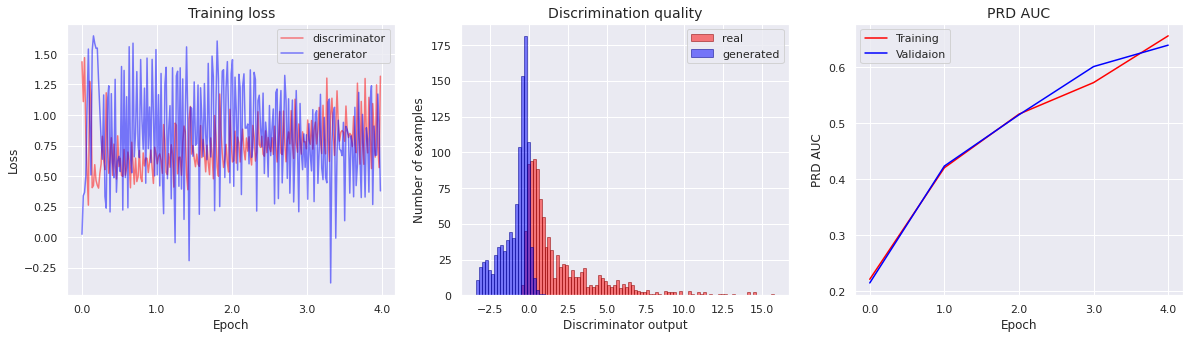

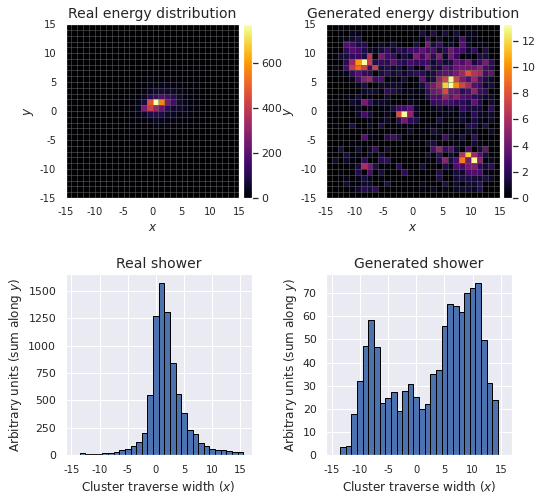

100%|██████████| 5/5 [14:39<00:00, 175.85s/it]


In [0]:
import pickle

N_EPOCHS  = 5
filename = '13.04_gan-vae_wasserstein.pt'

# Max train  dataset size = 50250
# Training   dataset size = 47178
# Validation dataset size = 3072

tr_class, pos_gen_models = train_model(N_EPOCHS, -123., train_size = 25197+25053-2*1536, valid_size = 2*1536,
                                       batch_size = 1024,
                                       discriminator = DeepDiscriminator(), 
                                       generator = DeepGenerator(vae_pretrained),
                                       vae_pretrained = vae_pretrained,
                                       dis_iter_num=2, gen_iter_num=1,
                                       loss_type='WASSERSTEIN')

with open(def_colab_path + filename, 'wb') as pickle_file:
    pickle.dump(tr_class, pickle_file)

Epoch #49
Mean discriminator output on real data = 1.31731
Mean discriminator output on generated data = 0.564981


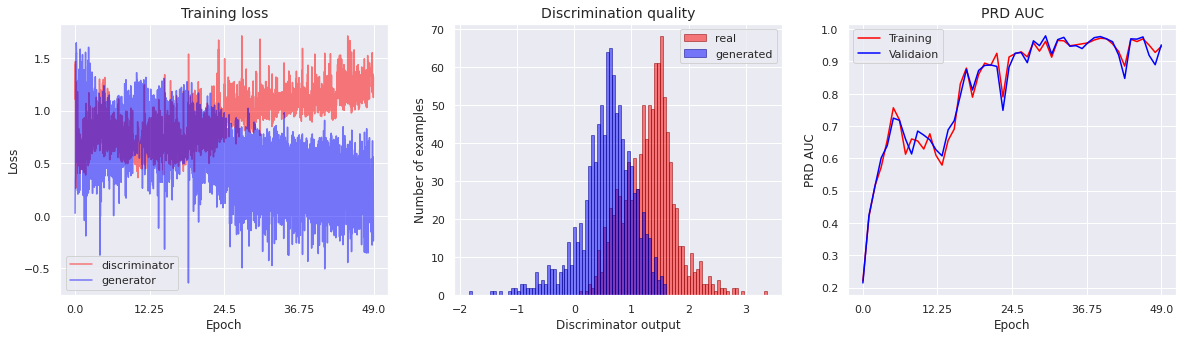

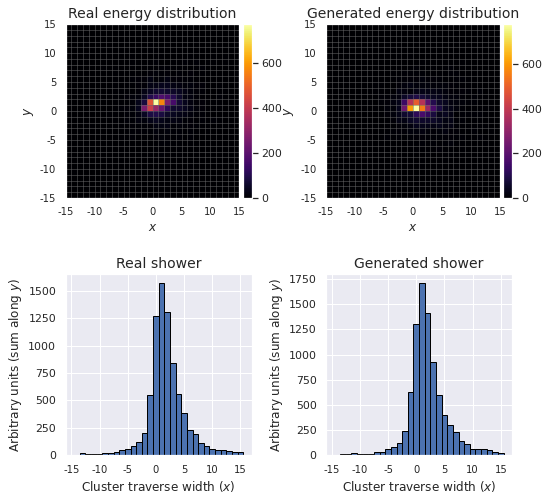

100%|██████████| 5/5 [15:06<00:00, 181.22s/it]


In [16]:
import pickle

filename = '13.04_gan-vae_wasserstein.pt'

for i in range(10):
    new_tr_class = None

    # load training class   
    with open(def_colab_path + filename, 'rb') as pickle_file:
        new_tr_class = pickle.load(pickle_file)

    new_tr_class.run(5 + i * 5, True)

    with open(def_colab_path + filename, 'wb') as pickle_file:
        pickle.dump(new_tr_class, pickle_file)
    
    del new_tr_class;

# best - epoch 32 (on train res)

### Hinge loss

Epoch #4
Mean discriminator output on real data = 2.1644
Mean discriminator output on generated data = -0.352789


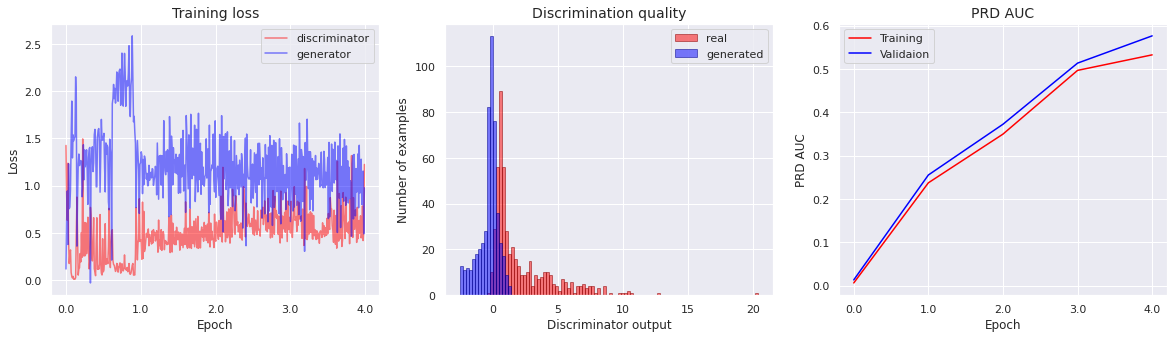

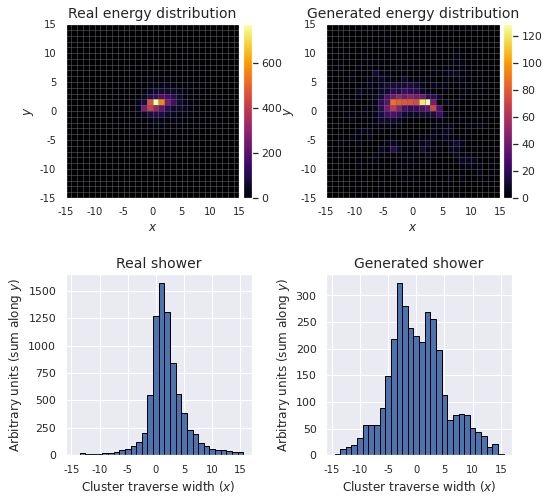





100%|██████████| 5/5 [30:51<00:00, 370.23s/it]


In [0]:
import pickle

N_EPOCHS  = 5
### filename = '12.04_gan-vae.pt'

# Max train  dataset size = 50250
# Training   dataset size = 47178
# Validation dataset size = 3072

tr_class, pos_gen_models = train_model(N_EPOCHS, -123., train_size = 25197+25053-2*1536, valid_size = 2*1536,
                                       discriminator = DeepDiscriminator(), 
                                       generator = DeepGenerator(vae_pretrained),
                                       vae_pretrained = vae_pretrained,
                                       dis_iter_num=2, gen_iter_num=1)

with open(def_colab_path + filename, 'wb') as pickle_file:
    pickle.dump(tr_class, pickle_file)

## Save model

In [0]:
filename = '13.04_gan-vae_wasserstein.pt'

with open(def_colab_path + filename, 'rb') as pickle_file:
    tr_class = pickle.load(pickle_file)

torch.save(tr_class.best_models[1].cpu().state_dict(), def_colab_path + 'vae_gan.pt')

In [0]:
#check_models(DeepDiscriminator(), DeepGenerator(vae_pretrained))